# Modelling butterfly wing eyespot patterns

In [1]:
import numpy as np
import scipy
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

![](Image/bicyclus.jpg)

## Étudions au préalable le laplacian en dimension deux :
Afin de pouvoir comprendre comment réaliser des résolutions numériques d'équation aux dérivées partielles en dimension deux contenant notament un opérateur laplacien de dimension 2, nous nous intéressons d'abord à l'équation de la chaleur en dimension 2 :
$$
\begin{align*}
\frac{\partial u}{\partial t}&=\sigma\nabla^2 u\\
\Leftrightarrow \frac{\partial u}{\partial t} &= \sigma (\frac{\partial^{2} u}{\partial^{2} x}+\frac{\partial^{2} u}{\partial^{2} y})
\end{align*}
$$

Pour $(t, x, y) \in \mathbb{R_+^*} \times [0,1] \times [0,1]$, une condition initiale u(0, x, y) = f(x) ainsi que des conditions aux limites.

On peut tout d'abord approximer l'opérateur du laplacien en utilisant la [méthode des différences finies](https://en.wikipedia.org/wiki/Finite_difference_method#Example:_The_Laplace_operator) :

$$
\begin{align*}
\frac{\partial^{2} u}{\partial^{2} x}+\frac{\partial^{2} u}{\partial^{2} y} &\approx \frac{u(t, x_{i+1}, y_j)-2u(t, x_i, y_j)+u(t, x_{i-1}, y_j)}{h^2} + \frac{u(t, x_{i}, y_{j+1})-2u(t, x_i, y_j)+u(t, x_i, y_{j-1})}{h^2} \\
\frac{\partial^{2} u}{\partial^{2} x}+\frac{\partial^{2} u}{\partial^{2} y}	 &\approx \frac{u(t, x_{i+1}, y_j) + u(t, x_{i}, y_{j+1}) - 4u(t, x_i, y_j) + u(t, x_{i-1}, y_j)+u(t, x_i, y_{j-1})}{h^2}
\end{align*}
$$

Ici nous nous intéresserons à 2 types de conditions aux limites :
- Condition aux limites de Neumann : n'impliquant aucuns flux entrants ou sortants de matière dans le domaine.
- Condition aux limites Dirichlet : imposant des valeurs à respecter aux frontières du modèle.

Lors du TP n°5, nous avons vu que sur l'intervalle $[0,1]$ nous pouvons réaliser un maillage à pas constant caractérisé par $M+1$ nœuds, séparer par un pas $h=\frac{1}{M}$, ce qui nous donne :
- pour $x$ : $x_i = ih,\, 0 \leq i \leq M$
- pour $y$ : $y_i = ih,\, 0 \leq i \leq M$

Ainsi, si on s'intéresse a une fonction de dimension 2 définie sur l'intervalle $[0,1] \times [0,1]$ on peut alors généraliser le cas précédent et on obtient ainsi un maillage de $M+1^2$ nœuds avec un pas $h=\frac{1}{M}$:
$$(x_i, x_j) = (ih, jh),\, 0\leq i \leq M, \, 0\leq j \leq M$$

Pour implémenter une résolution, nous allons nous appuyer sur la méthode des lignes en réalisant une semi-discrétisation de toutes les variables sauf une, ici le temps $t$ de telle sorte que $u(t,x_i,y_j) \approx u_{i,j}(t)$. On obtient alors la famille d'équation différentielle ordinaires suivante :
$$
\begin{align*}
\frac{du_{i,j}}{dt} \approx \sigma\frac{u_{i+1,j}(t) + u_{i,j+1}(t) - 4u_{i,j}(t) + u_{i-1,j}(t)+u_{i,j-1}(t)}{h^2}
\end{align*}
$$


### Utilisation d'un stencil
Suivant la méthode des différences finies on sait que le point $i,j$ dépend des points qui l'entoure sur la grille, sachant qu'un stencil est un arrangement géométrique d'un résaux nodale. Par exemple, dans notre cas, le laplacien de dimensions 2 se résume a l'aide du stencil suivant :
$$\nabla^2u(x,y) = \frac{1}{h^2} \begin{bmatrix}0 & 1 & 0 \\ 1 & -4 & 1\\ 0 & 1 & 0\end{bmatrix}$$

Comme nous sommes en dimensions 2, il va nous être plus facile d'utiliser une matrice $\mathcal{M}_{i,j}(\mathbb{R})$, avec chaque coefficient $a_{i,j}$ représentant le $u_{i,j}$ correspondant. Pour calculer le laplacien sur chacun des points nous allons utiliser la convolution et le stencil associé au laplacien comme matrice de convolution également appelée noyeau.

Rappelons tout d'abord que la convolution est le processus consistant à ajouter chaque élément de la matrice à ses voisins immédiats, pondéré par les coefficients de la matrice de convolution donc ici notre stencil comme représenter dans l'image suivante:
<center>
	<img src="Image/convolution.png"/>
</center>

Cependant, avec l'image, on peut facilement se rendre compte que cela ne marche pas pour les bords de notre matrice puisque la convolution nécessite des valeurs à l'extérieur des limites de l'image, d'autant plus qu'il faut prendre en compte les conditions au limites. C'est pourquoi il existe plusieur méthode dans la convolution pour palier a ce problème, ici nous ne nous intérésserons qu'a 2 méthode pour résoudre ce problèmes, 2 méthodes qui sont compatible avec nos conditions au limites :
- La méthode `Mirroir` : c'est a dire que la matrice est conceptuellement reflétée sur les bords, par exemple :

```
mode       |   Ext   |         Input          |   Ext
-----------+---------+------------------------+---------
'mirror'   | 4  3  2 | 1  2  3  4  5  6  7  8 | 7  6  5
```
C'est conceptuellement la méthode qui correpond au condition au limites de Neumann, en effet le stencil au niveau du bord gauche de la matrice est égale à $\nabla^2u(0,y) = \frac{1}{h^2} \begin{bmatrix}0 & 1 & 0 \\ 0 & -4 & 2\\ 0 & 1 & 0\end{bmatrix}$ puisque $\frac{\partial u}{\partial x}(t, 0, y) = 0$. Or on remarque que l'utilisation de la méthode du mirroire permet justement d'obtenir le même résultat que celui obtenu avec le stencil défini précédement.

- La méthode `Constante`: c'est-à-dire que les mêmes valeurs sont relfétée sur les bords :
```
mode       |   Ext   |         Input          |   Ext
-----------+---------+------------------------+---------
'constant' | 0  0  0 | 1  2  3  4  5  6  7  8 | 0  0  0
```
La valeur de la constante est modifiable, ici on se rapproche d'une condition initiale de Dirichlet, a la nuance près qu'on ne peut pas choisir spécifiquement pour chaque nœud la valeur de la constante, mais uniquement une constante globale. Cela n'est pas embêtant dans le cadre de notre projet puisque nous utiliserons sur notre modèle exclusivement la methode mirror, et utiliserons la méthode de la constante seulement lors de tests sur l'équation de la chaleur en dimension 2.

Implémentons alors la fonction `Laplacian_2D` qui permet de calculer l'application du stencil sur la matrice `u` en fonction du pas $h$ :

In [2]:
def Laplacian_2D(u: np.ndarray, h: int | float, boundary_condition: str = 'neumann',
				 cval: int | float = 0) -> np.ndarray:
	"""
    The Laplacian_2D function computes the tow-dimensional Laplacian of a 2D array.


    :param u:np.ndarray: Pass the input array
    :param h:int|float: Set the size of the stencil used in the convolution
    :param boundary_condition:str: Specify the boundary condition, default to 'neumann',
     in fact it's simply convert the boundary condition to the appropriate boundary method used in scipy
    :param cval:int|float: Set the value of the pixels outside the array if dirichlet boundary condition, default to 0
    :return: The two-dimensional laplacian of the input u
    """

	boundary_condition_to_mode = {'neumann': 'mirror', 'dirichlet': 'constant'}

	stencil = np.array([
		[0, 1, 0],
		[1, -4, 1],
		[0, 1, 0]
	]) / h ** 2

	return scipy.ndimage.convolve(u, stencil, mode=boundary_condition_to_mode[boundary_condition], cval=cval)

Maintenant une fois que nous avons implementer la fonction `Laplacian_2D(u, h, boundary_condition = 'neumann', cval = 0)` nous permettant de calculer l'approximation du laplacien nous pouvons implementer ce système de $M^2$ équations permetant de résoudre l'équation de la chaleur en dimension 2. Pour cela nous écrivons la fonction `Diffuse_2D(_, u, shape, h, sigma)`.

Ici on remarque l'utilisation d'un paramètre `shape`, en effet : le solveur `solve_ivp` ne peut utiliser qu'une matrice colonne d'équation et non pas une matrice d'équation. Ainsi pour faire fonctionner le solveur, on aplatit (utilisation de la méthode flatten) la matrice en une matrice colonne. Ensuite dans notre fonction, on peut à l'aide du paramètre `shape` restaurer la dimension initiale de notre matrice. Ensuite une fois le traitement effectuer il faut retransformer notre matrice en une matrice colonne et ainsi de suite.

In [3]:
def Diffuse_2D(_, u, shape, h, sigma):
	"""
    The Diffuse_2D function takes in a time t, an initial condition u at time t, the shape of the spatial grid (shape),
    the size of each grid cell (h), and a diffusion coefficient sigma. It returns the derivative du_dt at that point in time.
    
    :param t: Pass the time value to the function
    :param u: Pass the initial condition to the function
    :param shape: Reshape the array to a 2d matrix
    :param h: Define the size of the grid cells
    :param sigma: Define the diffusion coefficient
    :return: The change in concentration over time, given the initial concentration (u), the shape of the grid (shape), and diffusion coefficient sigma
    """
	u = u.reshape(shape)

	du_dt = sigma * Laplacian_2D(u, h, boundary_condition='dirichlet', cval=0)

	return du_dt.flatten()


Ensuite comme lors du TP n°5, il nous faut définir des conditions initiale afin de calculer l'évolution de la fonction sur un intervalle de temps $[0, T]$ via le solveur `solve_ivp`.
Pour cela on définit 2 fonctions permettant de définir 2 type de condition initiale :
- Une fonction périodique permettant une oscillation plusieurs fois sur l'intervalle $[0,1]$
- Une fonction aléatoire

In [4]:
def periodic_IC(x, k):
	"""
    The periodic_IC function takes two arguments, x and k.
    It returns the value of a function that is periodic with period 1 in the x variable.
    The function has a single parameter, k, which controls how much it deviates from being periodic.
    
    :param x: Define the position of the initial condition
    :param k: Determine the number of waves in the initial condition
    :return: A periodic function
    """
	return (1. + np.cos(2. * k * np.pi * x)) / 2.

In [5]:
def random_IC(x):
	"""
    The random_IC function takes a matrix as input and returns a randomly generated
    matrix of the same shape. This function is useful for testing purposes.
    
    :param x: Define the dimensions of the array
    :return: A numpy array of random numbers
    """
	return np.random.rand(x.shape[0], x.shape[1])

Nous sommes fins près pour appeler `solve_ivp` et réaliser notre première résolution numérique en dimension 2 :
Pour cela on définit tout d'abord les paramètres temporels, autrement dit l'intervalle de temps sur lequel on veut calculer la résolution numérique. Ensuite on définit les paramètres de l'espace, les paramètres physique (ici en occurrence juste sigma) et enfin la condition initiale. Puis nous appelons le solveur comme vu dans les précédents TP :

In [6]:
# time parameters
time_span = (0, 50.)
number_pts = 200
time_eval = np.linspace(time_span[0], time_span[1], number_pts)

# space parameters
M = 100
x = np.linspace(0., 1., M ** 2).reshape(M, M)
h = 1. / (M + 1.)

# physical parameter
sigma = 0.0002

# initial condition
# x = periodic_IC(x, np.pi)
x = random_IC(x)

sol = solve_ivp(Diffuse_2D, time_span, x.flatten(), args=(x.shape, h, sigma), t_eval=time_eval)

Une fois la résolution numérique terminer nous pouvons à présent representer graphiquement nos résultats. Ici nous ne pouvons pas nous permettre de réaliser un simple graphique en 2 dimensions, nous devons soit faire un graphique en trois dimensions, cependant les graphiques en 3D sont vite limité même si les méthodes et outils de représentation en trois dimensions s'améliore ça ne reste pas parfait. Or ici un simple graphique en deux dimensions et la couleur en troisième dimension nous permet de rester sur de la seconde dimension et ainsi une meilleure visualisation. Pour ce faire on s'appuie sur le code des animations vu au TP précédent dans lequel on remplace la fonction `plot` de matplotlib par la fonction `imshow` toujours de matplotlib. Elle permet de transformer une matrice en une image, prenant les index $x$ et $y$ comme des coordonée dans l'espace et la valeur de ce coefficient $a_{x,y}$ comme la couleur du pixel. Comme un pixel serait trop petit pour qu'on voie quelque chose, la fonction utilise une technique de mise à l'échelle afin d'avoir un graphique dans la bonne dimension.

On remarquera également qu'on définit les valeurs min et max afin d'éviter que la carte de couleur ne change tout le temps et qu'on ne voie rien. De même on dit à matplotlib d'utiliser une colormap qui correspond à la chaleur.

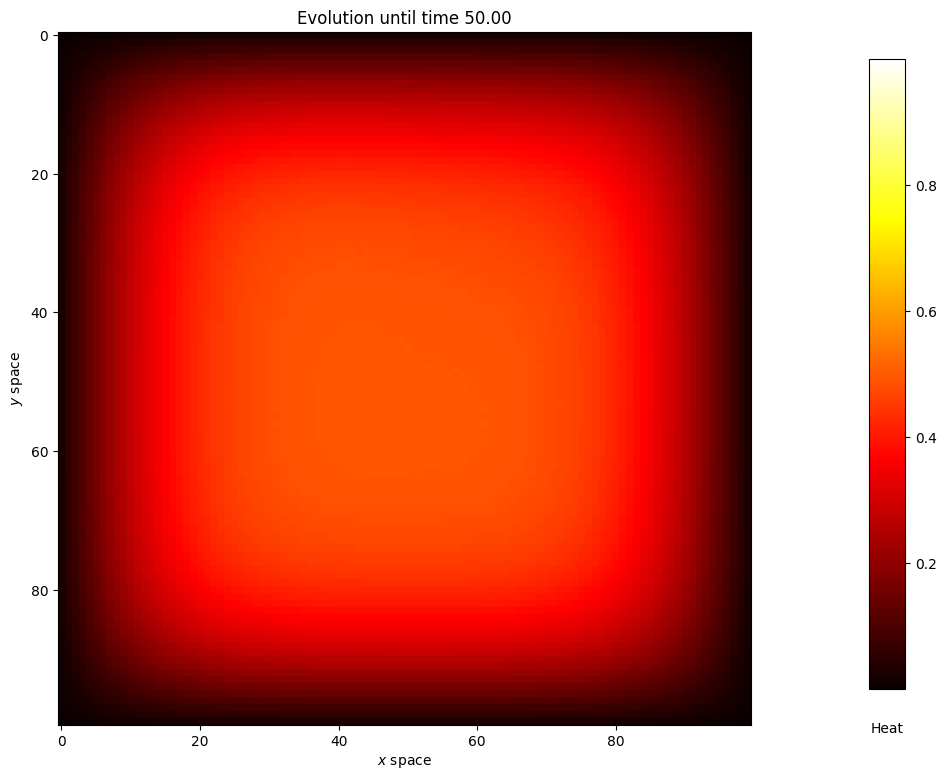

In [7]:
figure, axes = plt.subplots(1, 1, figsize=(12, 9))
image = axes.imshow(sol.y[:, 0].reshape(x.shape), vmin=np.amin(sol.y),
					vmax=np.amax(sol.y), cmap=plt.get_cmap('hot')) # use vmin and vmax to avoid legend (color) change.

# Since is only dissipating, plotting color-bar with y0 is okay since it's here we will have maximum values.
cbar_ax = figure.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('Heat', labelpad=20)
figure.colorbar(image, cax=cbar_ax)


# 2. initialize the line objects
def init():
	# axes.grid()
	axes.set_xlabel('$x$ space')
	axes.set_ylabel('$y$ space')
	return axes


# 3. animate function
def animate(i):
	axes.cla()
	axes.imshow(sol.y[:, i].reshape(x.shape), vmin=np.amin(sol.y),
				vmax=np.amax(sol.y), cmap=plt.get_cmap('hot'))  # use vmin and vmax to avoid legend (color) change.
	axes.set_title(f'Evolution until time {sol.t[i]:.2f}')
	axes.set_xlabel('$x$ space')
	axes.set_ylabel('$y$ space')
	return axes


# 4. call animation
fancy_plot = animation.FuncAnimation(figure, animate, frames=sol.t.size,
									 init_func=init, blit=False)

HTML(fancy_plot.to_jshtml())

## Modélisation des structures en formes d'œils sur les ailes de papillon
Qui n'a jamais vu ces fameux cercles en forme d'oeils sur les ailes de papillon ? La question que nous nous posons alors est comment modéliser ces fameuses structures. Avant de chercher a modéliser ces structures il faut tout d'abord chercher à comprendre comment ces structures apparaisse :


In [15]:
def function_test(t, u, shape, h, A0, k1=1.0, k2=0.05, k3=4.0, k4=0.01, k5=4.0, D1=0.002, D2=0.002):
	"""
    The function_test function computes the time derivatives for each of the species in a chemical reaction.
    
    :param t: Indicate the current time
    :param u: Pass the initial conditions to the function
    :param shape: Reshape the array into a matrix
    :param h: Define the step size of the numerical integration
    :param A0: Set the initial condition of the simulation
    :param k1=1.0: Set the value of a0
    :param k2=0.05: Set the value of k2
    :param k3=4.0: Define the rate of production of protein p0
    :param k4=0.01: Set the value of k4, which is the rate at which m2 decays into p0
    :param k5=4.0: Set the value of k5 in function_test
    :param D1=0.002: Set the diffusion coefficient of m2
    :param D2=0.002: Set the diffusion coefficient of p2
    :return: The derivative of the concentration of m and p with respect to time
    """
	M1, M2, P0, P1, P2 = np.split(u.reshape(shape[0] * 5, shape[1]), 5)

	A = A0 * np.exp(-k1 * t)

	dM1_dt = k1 * A - k2 * M1 - k3 * M1 * P0 + D1 * Laplacian_2D(M1, h)
	dM2_dt = k3 * M1 * P0 - k4 * M2 - k5 * M2 * P0 + D2 * Laplacian_2D(M2, h)
	dP0_dt = -k3 * M1 * P0 - k5 * M2 * P0
	dP1_dt = k3 * M1 * P0
	dP2_dt = k5 * M2 * P0

	return np.concatenate((dM1_dt, dM2_dt, dP0_dt, dP1_dt, dP2_dt)).flatten()

In [ ]:
time_span = (0., 50.)
number_pts = 1000
delta_t = 0.1
# time_eval = np.linspace(time_begin, time_end, number_pts)
time_eval = np.arange(time_span[0], time_span[1], delta_t)

# space parameters
M = 101
P1 = np.full((M, M), 0, dtype=float)
P2 = np.full((M, M), 0, dtype=float)
M1 = np.full((M, M), 0, dtype=float)
M2 = np.full((M, M), 0, dtype=float)
A0 = np.full((M, M), 0, dtype=float)
P0 = np.full((M, M), 0.2, dtype=float)

A0[M // 2 - 2:M // 2 + 3, M // 2 - 2:M // 2 + 3, ] = 20
P0[M // 2 - 2:M // 2 + 3, M // 2 - 2:M // 2 + 3, ] = 0
h = 1. / M

% time sol = solve_ivp(function_test, time_span, np.concatenate((M1, M2, P0, P1, P2)).flatten(), args=((M, M), h, A0), t_eval=time_eval)


In [ ]:

from src.model import Model

simu = Model()

simu.append_A0_pos([(10, 10)])
simu.solve()
sol = simu.solution

In [ ]:
def color_region(P0, P1, P2):
	"""
    The color_region function takes in three 2D arrays of probabilities and returns a 2D array
    of the same shape where each element is an integer value corresponding to a class. The function 
    uses argmax to determine which class has the highest probability for each pixel, and then returns 
    an array with these values.
    
    :param P0: Store the values of the first layer in the image
    :param P1: Specify the color of the pixel in p0 that is closest to p2
    :param P2: Determine the color of the pixel
    :return: A numpy array of the same size as p0, p1 and p2
    """
	color = np.empty(P0.shape)
	for (x, y), value in np.ndenumerate(P0):
		# print(np.array([P0[x, y], P1[x,y], P2[x,y]]))
		match np.argmax(np.array([P0[x, y], P1[x, y], P2[x, y]])):
			case 0.:
				color[x, y] = 0
			case 1.:
				color[x, y] = 1
			case 2.:
				color[x, y] = 2
	return color


In [ ]:
x = np.arange(0, M, 1)
M1, M2, P0, P1, P2 = np.split(sol.y[:, 0].reshape(M * 5, M), 5)
figure, axes = plt.subplots(1, 1, figsize=(12, 9))
lineM1, = axes.plot(x, M1[M // 2, :])
lineM2, = axes.plot(x, M2[M // 2, :])
lineP0, = axes.plot(x, P0[M // 2, :])
lineP1, = axes.plot(x, P1[M // 2, :])
lineP2, = axes.plot(x, P2[M // 2, :])


# 2. initialize the line objects
def init():
	axes.set_xlim(x.min(), x.max())
	axes.set_ylim(0., .4)
	axes.grid()
	axes.set_xlabel('space')
	axes.set_ylabel('u')
	return axes


# 3. animate function
def animate(i):
	M1, M2, P0, P1, P2 = np.split(sol.y[:, i].reshape(M * 5, M), 5)
	lineM1.set_data(x, M1[M // 2, :])
	lineM2.set_data(x, M2[M // 2, :])
	lineP0.set_data(x, P0[M // 2, :])
	lineP1.set_data(x, P1[M // 2, :])
	lineP2.set_data(x, P2[M // 2, :])

	axes.set_title(f'Evolution until time {sol.t[i]:.2f}')
	return axes


# 4. call animation
fancy_plot = animation.FuncAnimation(figure, animate, frames=sol.t.size,
									 init_func=init, blit=False)

HTML(fancy_plot.to_jshtml())

In [ ]:
simu = Model(time_span=(0, 30))

simu.append_A0_pos([
	(49, 49), (50, 49), (51, 49),
	(49, 50), (50, 50), (51, 50),
	(49, 51), (50, 51), (51, 51),
])
simu.solve()
sol = simu.solution

In [ ]:
M1, _, P0, P1, P2 = np.split(sol.y[:, 0].reshape(M * 5, M), 5)
figure, axes = plt.subplots(1, 1, figsize=(12, 9))
_ = axes.imshow(color_region(P0, P1, P2), vmin=0, vmax=2)


# 2. initialize the line objects
def init():
	# axes.set_xlim(x.min(), x.max())
	# axes.set_ylim(0., 1.)
	# axes.grid()
	# axes.set_xlabel('space')
	# axes.set_ylabel('u')
	return axes


# 3. animate function
def animate(i):
	axes.cla()
	M1, M2, P0, P1, P2 = np.split(sol.y[:, i].reshape(M * 5, M), 5)
	axes.imshow(color_region(P0, P1, P2), vmin=0, vmax=2)  # use vmin and vmax to avoid legend (color) change.
	# print(sol.y[:,i])
	axes.set_title(f'Evolution until time {sol.t[i]:.2f}')
	#    figure.suptitle(f'Evolution until time {sol.t[i]:.2f}')
	return axes


# 4. call animation
fancy_plot = animation.FuncAnimation(figure, animate, frames=sol.t.size,
									 init_func=init, blit=False)

HTML(fancy_plot.to_jshtml())